## Calculation of the Current Carrying Capacity of Buried Cables with C4_open
### Example for ac multi-core cables with cyclic loads

### Importing the modules

In [46]:
# Generic modules
import pandas as pd
import os

# C4 modules
from c4_open.project import Project
from c4_open.cables import Cable
from c4_open.cyclic_rating_factors import FactorM
from c4_open.load_profile import LoadProfile
from c4_open import arrangements

# Import project directory
from c4_open.config import project_directory

### Defining the Project Data
The project data describes the arrangement of the cable and operational conditions. It is summarized in a dictionary with keys according to the following example. For the 'Calculation Case' one of the following values must be selected:

* *'ac_sc'*:      Calculation for ac single-core cables
* *'ac_sc_pipe'*: Calculation for ac single-core cables, laid in buried pipe
* *'dc_sc'*:      Calculation for dc single-core cables
* *'dc_sc_pipe'*: Calculation for dc single-core cables, laid in buried pipe
* *'ac_mc'*:      Calculation for ac multi-core cables
* *'ac_mc_pipe'*: Calculation for ac multi-core cables, laid in buried pipe

The optional values are only required for the calculation of cables in pipes (*N*, *dpipe_in*, *dpipe_out*, *rho_pipe* and *theta_mean*) or the calculation of cyclic rating factors (*Y_i* and *mu*).

In [47]:
project_parameters = {'name': 'ac multicore cable',
                      'calc_case': 'ac_mc',
                      'F': 1,               # Mutual heating factor F
                      'K': '',              # Number of cables in pipe (optional)
                      'L': 0.7,             # Depth of laying
                      'N': 1,               # Total number of parallel cables (or pipes)
                      'U_0': 462,         # Phase-ground voltage (only for ac cables)
                      'U_n': 800,         # Phase-phase voltage (only for ac cables)
                      'f': 50,              # Mains frequency     
                      'cable_type': 'NAYY-J 4x240',  # Cable type according to 'cable_data.xlsx'
                      'deltatheta_x': 15,   # Critical temperature rise of soil above drying of soil occurs
                      'dpipe_in': '',       # Inner pipe diameter (optional)
                      'dpipe_out': '',      # External pipe diameter (optional)   
                      'theta_mean': '',     # Mean air temperature inside pipe (optional), 
                                            # a good assumption is mean of ambient temperature and max. conductor temperature  
                      'rho_T4': 1,          # Thermal resistivity of soil
                      'rho_pipe': '',       # Thermal resistivity of pipe material (optional)
                      'theta_amb': 20,      # Ambient temperature
                      
                      }

### Create the project object

In [48]:
project = Project(**project_parameters)

### Calculating the mutual heating factor and updating the project parameters
This step is optional and for the case the mutual heating factor of groups of cables is not already given in the *projects_parameters* and must be calculated. In this case the mutual heating factor is calculated using the 'create_arrangement' function from the module 'arrangements'.

In [49]:
# The calculation functions requires the laying depth of the cable and the exernal cable diameter in 
# units of m. The cable diameter and the laying depth are taken from the project object.
F,_,_,_ = arrangements.create_arrangement('single', 2, project.D_e / 1000, 0.07, project.L)

# Save the mutual heating factor F in the project object
project.F = F

### Create the load profile object
For the calculation of the load profile parameters the *LoadProfile* class can be used. It processes the parameters from data provided in an .xlsx., which must meet the following requirements:
* The column with the load profile data must be labeled with *'load'*
* Must comprise hourly values for one day, e.g. 24 values
The method *LoadProfile.get_parameters()* returns a dictionary with the required parameters. 

In [50]:
path = os.path.join(project_directory, './examples/example_load_profile.xlsx')
load_profile = LoadProfile(path)
load_profile_parameters = load_profile.get_parameters()
project_parameters.update(load_profile_parameters)
# Converted to DataFrame for better readability only
print(pd.DataFrame.from_dict(project_parameters, orient='index'))

# Update the delta_theta_x of the project
project.get_delta_theta_x(load_profile)

                               0
name          ac multicore cable
calc_case                  ac_mc
F                              1
K                               
L                            0.7
N                              1
U_0                          462
U_n                          800
f                             50
cable_type       NAYY-J 4x240mm²
deltatheta_x           35.037858
dpipe_in                        
dpipe_out                       
theta_mean                      
rho_T4                         1
rho_pipe                        
theta_amb                     20
Y_0                          1.0
Y_1                          1.0
Y_2                          1.0
Y_3                          1.0
Y_4                          1.0
Y_5                     0.727687
mu                      0.328415
m                       0.398563
Y_0_hour                      13


### Plotting load profile
The method *LoadProfile.get_results()* returns a DataFrame with the load profile parameters which can be plotted in a very simple way.

<Axes: >

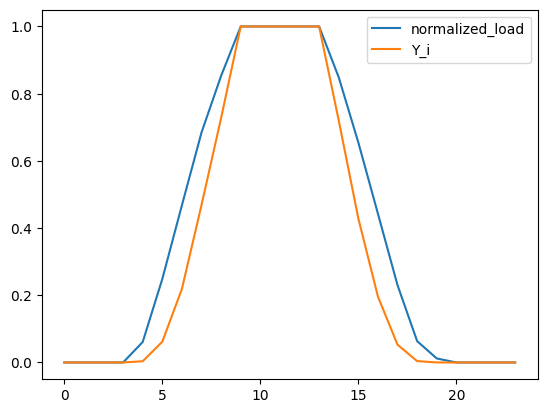

In [51]:
load_profile.get_results().plot()

### Create the cable object
To create a *cable* object the *project* object is required as the first argument. The optional argument *external_resistance_method* allows to chose a specific method to calculate the external thermal resistance of the cable *T_4*. Possible options are *'three_trefoil'*, *'three_flat'* and *'two_flat'* If no option is set, the default method *'from_F'* will be considered and the external thermal resistance will be calculated by using the mutual heating factor *F* as defined in the *project*.

The method Cable.get_result() will return a dictionary with the most relevant calculation results incl. two current carryng capacities. *I (no dryzone)* is 
calculated by ignoring a potentially arising dry zone while *I (with dryzone)* is the value considering a dry zone.

In [52]:
cable = Cable(project)
ampacities = cable.get_result()

# Converted to DataFrame for better readability only
print(pd.DataFrame.from_dict(ampacities, orient='index'))

                            0
Y_s                  0.003645
Y_p                  0.007126
R                    0.000152
W_d                  0.000233
T_1                  0.286453
T_3                  0.090420
T_4                  1.014751
I (no dry zone)    302.579656
I (with dry zone)  287.765806


### Calculating the Cyclic Rating Factor M
The *FactorM* class provides a simple interface to the different calculation functions depending on the calculation case. The method *FactorM.get_result()* returns a dictionary with the factors:
* *M (with dry zone)*:    Cyclic rating factor for current corresponding to a steady state current carrying capacity considering a dry zone around the cable  
* *M_1 (with dry zone)*:  Cyclic rating factor corrected for moisture migration for calculations considering a dry zone; in case the surface temperatur doesn't exceed the critical temperature rise (*delta_theta_x*), moisture migration will not occure and the method will return 'None' 
* *M (no dry zone)*:      Cyclic rating factor for current corresponding to a steady state current carrying capacity without considering a dry zone around the cable  


In [53]:
M = FactorM(cable, load_profile)
cyclic_rating_factors = M.get_result()
# Converted to DataFrame for better readability only
print(pd.DataFrame.from_dict(cyclic_rating_factors, orient='index')) 

                          0
M (with dry zone)  1.103688
M_1                     NaN
M (no dry zone)    1.116624


### Final Result
In this example case no value for *M_1* is returned. This means that no dry zone around the cable will arise under the given cyclic load and cable arrangement. Therefore the calculated current carrying capacity without dry zone around the cable *I (no dry zone)* must be taken and multiplied with the value for *M (no dry zone)*. The result is the current carrying capacity of the cable under the given cyclic load.

In [54]:
I = ampacities['I (no dry zone)'] * cyclic_rating_factors['M (no dry zone)']
print('Current carrying capacity [A]:', round(I, 1))

Current carrying capacity [A]: 337.9


### Reports

In [55]:
report = cable.get_report()
print(pd.Series(report))

cable_type              NAYY-J 4x240mm²
theta_max                          70.0
R__20                          0.000125
alpha_con                         0.004
R_                              0.00015
C                                   0.0
R__scr20                            NaN
alpha_scr                           NaN
d_out                              54.0
t_ins                               2.2
t_sheath                            2.9
n                                     3
rho_T1                              5.0
rho_T3                              5.0
d_a                                48.2
r_1                                21.6
U_n                               800.0
U_0                               462.0
f                                  50.0
L                                   0.7
factor_F                      11.334522
rho_T4                              1.0
theta_amb                          20.0
deltatheta_x                  35.037858
Y_s                            0.003645


In [57]:
report = M.get_report()
print(pd.Series(report))

W            37.665711
L             0.700000
d_out        54.000000
rho_T4        1.000000
theta_amb    20.000000
theta_max    70.000000
mu            0.328415
Y_0           1.000000
Y_1           1.000000
Y_2           1.000000
Y_3           1.000000
Y_4           1.000000
Y_5           0.727687
k             0.473387
beta_1        0.229421
beta_2        0.311024
beta_3        0.360277
beta_4        0.395654
beta_5        0.423278
beta_6        0.445943
phi_0         0.229421
phi_1         0.081602
phi_2         0.049253
phi_3         0.035377
phi_4         0.027624
phi_5         0.022665
B                  NaN
M             1.116624
theta_SPK          NaN
M_1                NaN
dtype: float64
